In [1]:
#import des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import de tensorflow et keras
import tensorflow as tf
import keras

In [3]:
import PIL
from PIL import Image
import os
from os import path

# Chargement du jeu de données :
def load_signaux(dir):
    img_list = []
    class_counter = 0
    class_list = []
    for i in os.listdir(dir):
        if (path.isdir(path.join(dir, i))):
            for j in os.listdir(path.join(dir, i)):
                if (j.endswith('.ppm')):
                    class_list.append(class_counter)
                    img_list.append(np.array(Image.open(os.path.join(os.path.join(dir, i), j)).resize((28, 28))))
            class_counter += 1
    return np.array(img_list), np.array(class_list)

In [4]:
# Chargement des données en train/test
(X_train, y_train)=load_signaux('Train')
(X_test, y_test)=load_signaux('Test')

In [5]:
#découpage des données train en train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [6]:
X_train.shape

(3431, 28, 28, 3)

In [7]:
#enregistrement du nombre de catégories
class_list=np.unique(y_train)

In [8]:
#vérification: il y'a 62 catégories différentes 
class_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

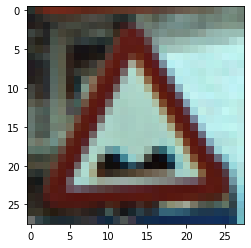

In [9]:
#visualisation de la 1ere immage test
plt.imshow(X_test[0])

In [10]:
#normalisation des données
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

In [11]:
#instentiation du modèle
model = keras.Sequential()
model.add(keras.layers.Conv2D(128,(3,3),input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(256,(3,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(62,activation='softmax'))

In [12]:
#sommaire du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3277312   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [13]:
#compilation du modèle
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
#chargement tensorboard
%load_ext tensorboard

In [15]:
#ajout de la date sur fichiers entrainements
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [16]:
#définition des callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint('best_model_signaux6.h5',save_best_only=True)
]

In [17]:
#enregistrement de l'entrainement du modèle
history = model.fit(X_train,y_train,callbacks=callbacks,epochs=7,validation_data=(X_val,y_val))

Epoch 1/7
108/108 [==============================] - 56s 479ms/step - loss: 2.4536 - accuracy: 0.4410 - val_loss: 0.3964 - val_accuracy: 0.8951
Epoch 2/7
108/108 [==============================] - 48s 443ms/step - loss: 0.3702 - accuracy: 0.9098 - val_loss: 0.1993 - val_accuracy: 0.9537
Epoch 3/7
108/108 [==============================] - 49s 456ms/step - loss: 0.1244 - accuracy: 0.9703 - val_loss: 0.1270 - val_accuracy: 0.9712
Epoch 4/7
108/108 [==============================] - 48s 445ms/step - loss: 0.0731 - accuracy: 0.9867 - val_loss: 0.1120 - val_accuracy: 0.9720
Epoch 5/7
108/108 [==============================] - 47s 439ms/step - loss: 0.0702 - accuracy: 0.9814 - val_loss: 0.1453 - val_accuracy: 0.9554
Epoch 6/7
108/108 [==============================] - 31s 287ms/step - loss: 0.0497 - accuracy: 0.9857 - val_loss: 0.1275 - val_accuracy: 0.9703
Epoch 7/7
108/108 [==============================] - 30s 276ms/step - loss: 0.0604 - accuracy: 0.9857 - val_loss: 0.1193 - val_accuracy:

In [56]:
#vérification de la précision
model = keras.models.load_model('best_model_signaux6.h5')
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

79/79 [==============================] - 7s 92ms/step - loss: 0.1712 - accuracy: 0.9667
Test accuracy: 0.9666666388511658
Test loss: 0.17120300233364105


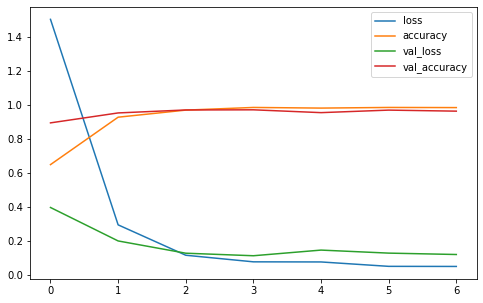

In [19]:
#visualisation hitorique entrainement
pd.DataFrame(history.history).plot(figsize=(8,5))

In [40]:
#fonction tensorboard
def tb(logdir=log_dir, port=6006, open_tab=True, sleep=2):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port))
    if open_tab:
        import time
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

In [41]:
#lancement de tensorboard
server =tb()

In [42]:
#arret tensorboard
server.kill()